# Task1 Data Generation
We created a Wechat group of **6 people**, where each person sent **50 WREs**, each containing **50r**, distributed to all 6 people.

That is to say, totally **300 i.i.d. samples from the distribution**.

# Task2 Data Processing
## Raw Info Collecting
We made use of an auto-test software **Airtest**(Based on Image Recognition) to traverse the ChatLog to get **Snapshots of WRE Reception Record Infos**.
## Data Extracting and Processing
We deployed **gemma3** model with **Ollama** on **WSL** and **Dify** with **Docker** on **Windows Host**. Gemma3 is able to **read images**.

Then we built a workflow on **Dify**, which is able to call **gemma3** to extract **Receiver Order Index** and **Receive Amount** from the **Snapshots**, and **structure-output json files** for later processing.

Then we wrote 2 python scripts:
- **DataExtractor.py** : Making use of **Dify's API** to **upload snapshots** and **get the returned jsons**.
- **DataProcessor.py** : 
  - Get input snapshots
  - Call DataExtractor.py in loops
  - Do postprocess and output data as a json file
  
### Visualization
**Datavisualizer.py**
- A **Scatter** showing how much **receivers with different Receiver Order Index** receives   (*x:index* - *y:amount*)
- A **Boxplot** showing how much **receivers with different Receiver Order Index** receives   (*x:index* - *y:amount*)
- 6 **Histograms** showing the distribution of each receiver with different **Receiver Order Index**'s receive amount   (*x:amount* - *y:frequency*)

In [ ]:
import requests
import json
import os
import mimetypes
import glob
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["font.sans-serif"] = ["Microsoft YaHei", "SimHei", "DejaVu Sans"]


## DataExtractor

In [13]:
# ====== Configuration ======
LOCAL_DIFY_URL = "http://localhost"
API_KEY = "app-5Wjz73iI02lHt23TiDULPkIL"
USER_ID = "PositionZero"
# IMAGE_PATH = "./Snapshots/info0.png"
# SAVE_PATH = "./result.json"


def upload_file(file_path, user, base_url, api_key):
    upload_url = f"{base_url}/v1/files/upload"
    headers = {
        "Authorization": f"Bearer {api_key}",
    }

    try:
        # print(f"正在上传图片: {os.path.basename(file_path)}")
        with open(file_path, "rb") as file:
            mime_type, _ = mimetypes.guess_type(file_path)
            if not mime_type:
                mime_type = "application/octet-stream"

            files = {"file": (os.path.basename(file_path), file, mime_type)}
            data = {"user": user}

            response = requests.post(
                upload_url, headers=headers, files=files, data=data, timeout=60
            )
            if response.status_code == 201 or response.status_code == 200:
                # print("✅ 文件上传成功")
                return response.json()
            else:
                print(f"❌ 文件上传失败，状态码: {response.status_code}")
                try:
                    print(response.json())
                except:
                    print(response.text)
                return None
    except Exception as e:
        print(f"❌ 上传发生错误: {str(e)}")
        return None


def run_workflow(file_id, user, base_url, api_key, response_mode="blocking"):
    workflow_url = f"{base_url}/v1/workflows/run"
    headers = {"Authorization": f"Bearer {api_key}", "Content-Type": "application/json"}

    data = {
        "inputs": {
            "RedPacketInfo": {
                "transfer_method": "local_file",
                "upload_file_id": file_id,
                "type": "image",
            }
        },
        "response_mode": response_mode,
        "user": user,
    }

    try:
        # print("正在调用工作流运行接口...")
        response = requests.post(workflow_url, headers=headers, json=data, timeout=120)
        if response.status_code == 200:
            # print("✅ 工作流执行成功")
            return response.json()
        else:
            print(f"❌ 工作流执行失败，状态码: {response.status_code}")
            try:
                print(response.json())
            except:
                print(response.text)
            return {
                "status": "error",
                "message": f"Failed to execute workflow, status code: {response.status_code}",
            }
    except Exception as e:
        print(f"❌ 运行发生错误: {str(e)}")
        return {"status": "error", "message": str(e)}


def extract_data_from_image(
    image_path, user_id=USER_ID, base_url=LOCAL_DIFY_URL, api_key=API_KEY
):
    if not os.path.exists(image_path):
        print(f"❌ 找不到图片文件，请检查路径：{image_path}")
        return None

    upload_resp = upload_file(image_path, user_id, base_url, api_key)

    if upload_resp and "id" in upload_resp:
        file_id = upload_resp["id"]
        # print(f"上传文件ID: {file_id}")

        run_resp = run_workflow(file_id, user_id, base_url, api_key)

        # 解析 run 响应以提取 outputs
        run_output = None
        if (
            isinstance(run_resp, dict)
            and "data" in run_resp
            and isinstance(run_resp["data"], dict)
            and "outputs" in run_resp["data"]
        ):
            run_output = run_resp["data"]["outputs"]
        else:
            run_output = run_resp

        try:
            text_content = run_output.get("text")
            if "```json" in text_content:
                text_content = text_content.replace("```json", "").replace("```", "")

            parsed_json = json.loads(text_content)

            # Attempt to locate the list of items
            info = None
            if isinstance(parsed_json, dict):
                # 1. Try exact match
                if "red_packets" in parsed_json:
                    info = parsed_json["red_packets"]
                # 2. Search for any list value if specific key is missing
                else:
                    for key, value in parsed_json.items():
                        if isinstance(value, list):
                            # print(
                            #     f"⚠️ Note: 'red_packets' key missing. Using '{key}' key."
                            # )
                            info = value
                            break
            elif isinstance(parsed_json, list):
                # 3. The root object itself is the list
                info = parsed_json

            if info is None:
                raise ValueError("Cannot locate a valid data list in response.")

            data = []
            for i in range(len(info) - 1, -1, -1):
                amount_str = info[i].get("ReceiveAmount", "0")
                amount_str = str(amount_str).replace("元", "")
                data.append(float(amount_str))
            return data
        except Exception as e:
            print(f"Error parsing data: {e}")
            return None

    else:
        print("文件上传失败，无法执行工作流")
        return None


## DataProcessor

In [14]:
PLOTS_DIR = "Plots/Raw_Wechat/"
OUTPUT_DIR = "Output/"  # Temporary output directory for test-generated data
DATABASE_DIR = "Database/"  # Acknowledged and manually transferred long-term data storage from OUTPUT_DIR

def process_all_snapshots():
    # Cleanup: Delete all temp generated .jpgs in Snapshots/
    jpg_files = glob.glob(os.path.join("Snapshots", "*.jpg"))
    if jpg_files:
        print(f"Cleaning up {len(jpg_files)} .jpg files in Snapshots/...")
        for f in jpg_files:
            try:
                os.remove(f)
            except Exception as e:
                print(f"Failed to delete {f}: {e}")

    snapshot_files = glob.glob(os.path.join("Snapshots", "info*.png"))

    snapshot_files.sort()

    all_data = []

    print(f"Found {len(snapshot_files)} files: {snapshot_files}")

    for file_path in snapshot_files:
        if not os.path.exists(file_path):
            print(f"File not found: {file_path}")
            continue

        print(f"Processing {file_path}...")

        file_data = extract_data_from_image(file_path)

        if file_data:
            all_data.append(file_data)
            print(f"Extracted {len(file_data)} items from {file_path}")
        else:
            print(f"Failed to extract data from {file_path}")

    if not all_data:
        print("No data collected.")
        return

    print(f"Collected data groups: {len(all_data)}")

    # Save all_data to a JSON
    output_json_path = os.path.join(OUTPUT_DIR, "Wechat_Samples.json")

    try:
        with open(output_json_path, "w", encoding="utf-8") as f:
            json.dump(all_data, f, ensure_ascii=False, indent=4)
        print(f"All data saved to {output_json_path}")
    except Exception as e:
        print(f"Error saving data to file: {e}")


## DataVisualizer

In [15]:
def visualize_data(all_data):
    plt.figure(figsize=(12, 6))

    # Data logic for plotting
    # Example: all_data = [[A1, B1], [A2, B2], [A3, B3]]
    # Index 0 (A): Values (A1, A2, A3)
    # Index 1 (B): Values (B1, B2, B3)

    # Determine maximum dimension length
    max_len = max(len(d) for d in all_data) if all_data else 0

    if not os.path.exists(PLOTS_DIR):
        os.makedirs(PLOTS_DIR)

    # 1. Overlay Plot: Vertical Scatter (Index vs Value)
    plt.figure(figsize=(12, 6))

    # 1. Prepare data by dimension
    data_by_dimension = []
    for dim_idx in range(max_len):
        values = [snap[dim_idx] for snap in all_data if dim_idx < len(snap)]
        data_by_dimension.append(values)

    # 2. Overlay Plot: Vertical Scatter (Index vs Value)
    plt.figure(figsize=(12, 6))

    for dim_idx, values in enumerate(data_by_dimension):
        if values:
            # Add random jitter to x coordinates
            jitter = np.random.uniform(-0.1, 0.1, len(values))
            x = np.array([dim_idx] * len(values)) + jitter

            plt.scatter(
                x,
                values,
                alpha=0.6,
                s=50,
                label=f"Dim {dim_idx}" if dim_idx == 0 else "",
            )

    plt.title("All Value Distribution (Scatter)")
    plt.xlabel("Receiver Order Index")
    plt.ylabel("Value (元)")
    plt.xticks(range(max_len))
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    # all_plot_path = os.path.join(PLOT_DIR, "all_value_scatter.png")
    # plt.savefig(all_plot_path)
    # print(f"Combined plot saved to {all_plot_path}")
    plt.show()

    # 3. Overlay Plot: Vertical Boxplot (Index vs Value)
    plt.figure(figsize=(12, 6))
    plt.boxplot(data_by_dimension, tick_labels=range(max_len))

    plt.title("All Value Distribution (Boxplot)")
    plt.xlabel("Receiver Order Index")
    plt.ylabel("Value (元)")
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    # boxplot_path = os.path.join(PLOT_DIR, "all_value_boxplot.png")
    # plt.savefig(boxplot_path)
    # print(f"Boxplot saved to {boxplot_path}")
    plt.show()

    # 4. Individual Plots: Histogram (Value Distribution)

    # print("Generating individual histograms...")

    for dim_idx, values in enumerate(data_by_dimension):
        if not values:
            continue

        plt.figure(figsize=(10, 6))

        plt.hist(values, bins=20, color="teal", alpha=0.7, edgecolor="black")

        plt.title(f"Distribution Histogram for Receiver # {dim_idx}")
        plt.xlabel("Value (元)")
        plt.ylabel("Frequency")
        plt.grid(axis="y", linestyle="--", alpha=0.7)

        # filename = os.path.join(PLOTS_DIR, f"Receiver_Index_{dim_idx}_hist.png")
        # plt.savefig(filename)
        plt.show()

    # print(f"Individual histograms saved to {PLOTS_DIR}")

## Main

Loading data from Database/Wechat_Samples.json...


<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

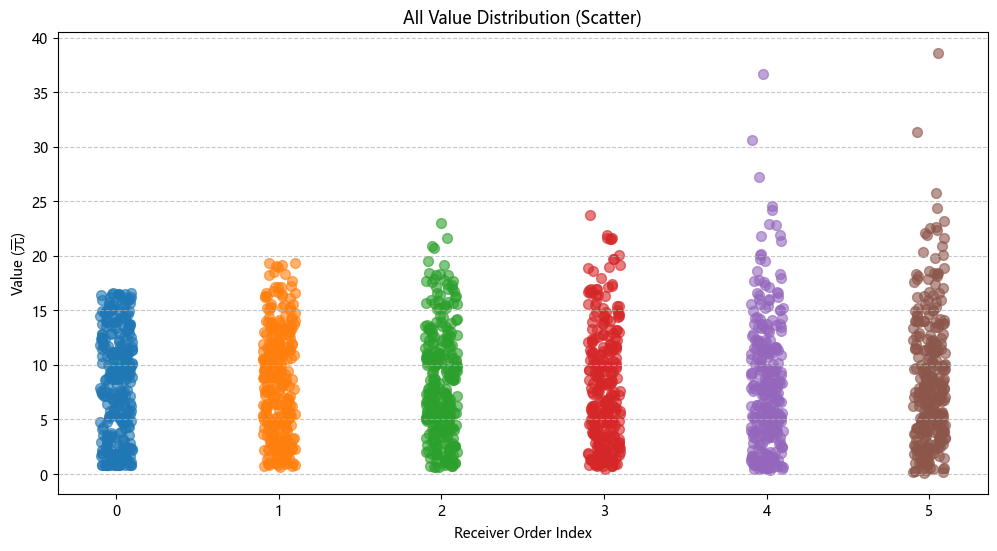

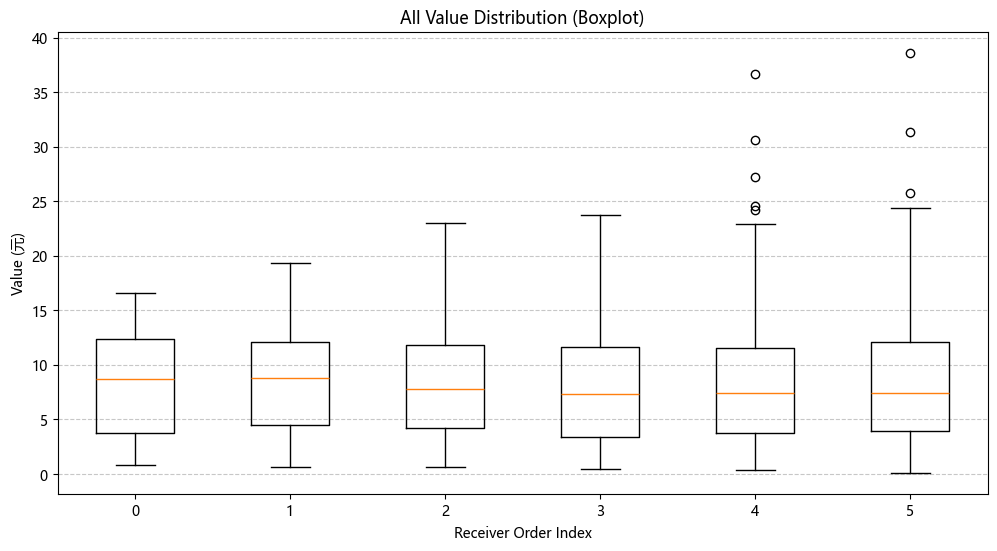

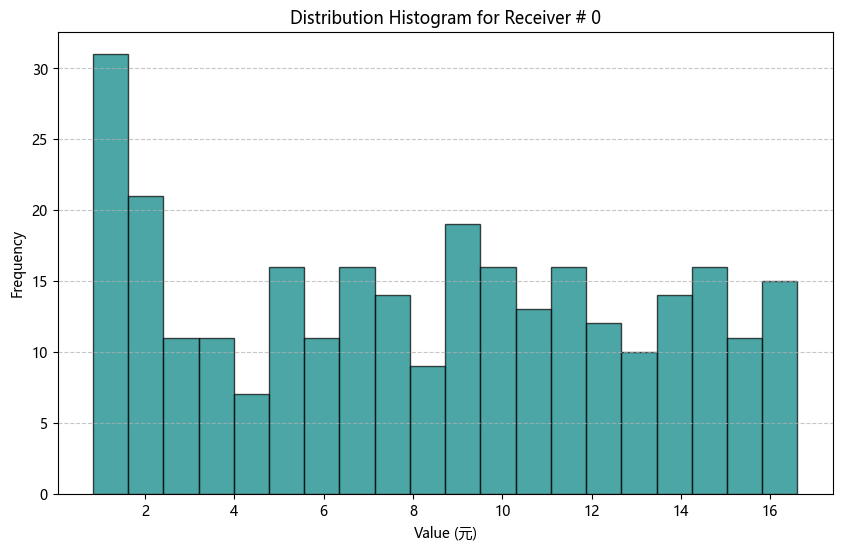

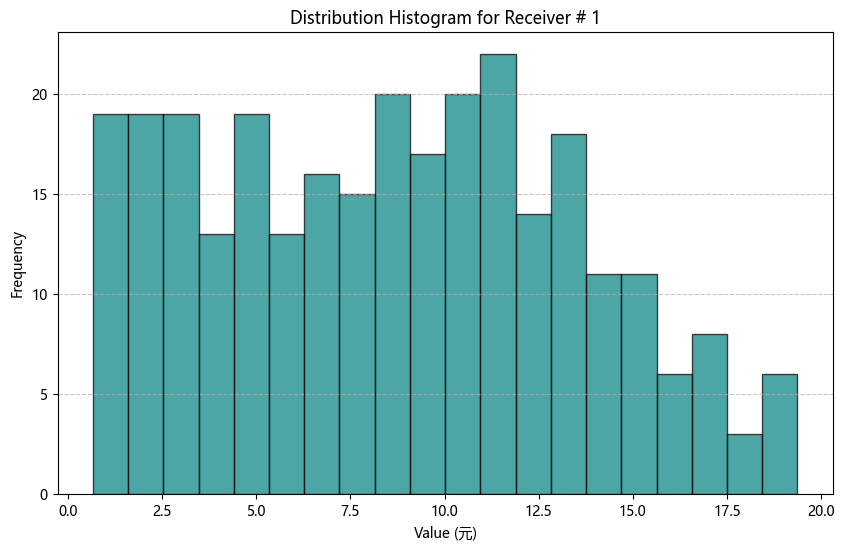

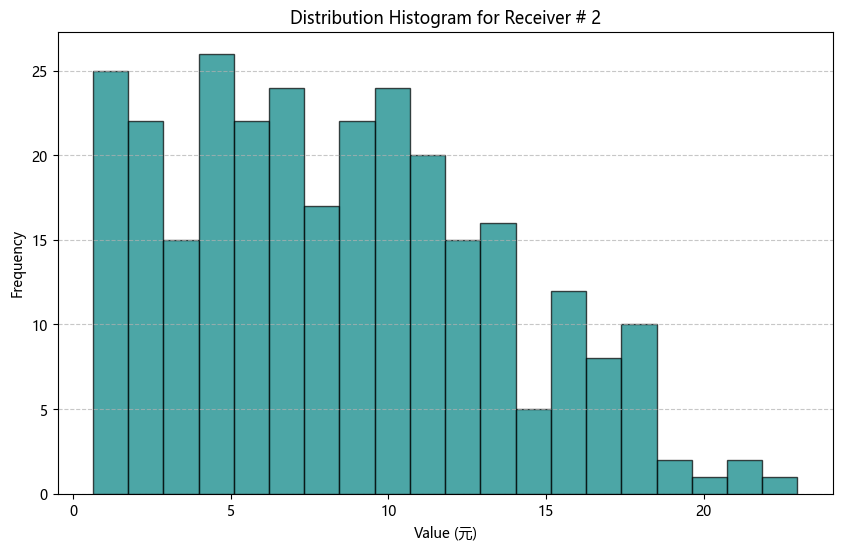

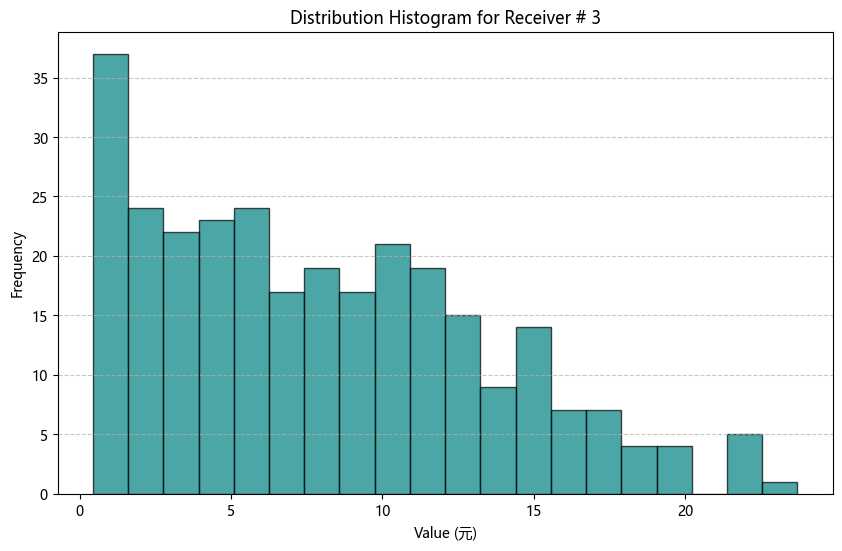

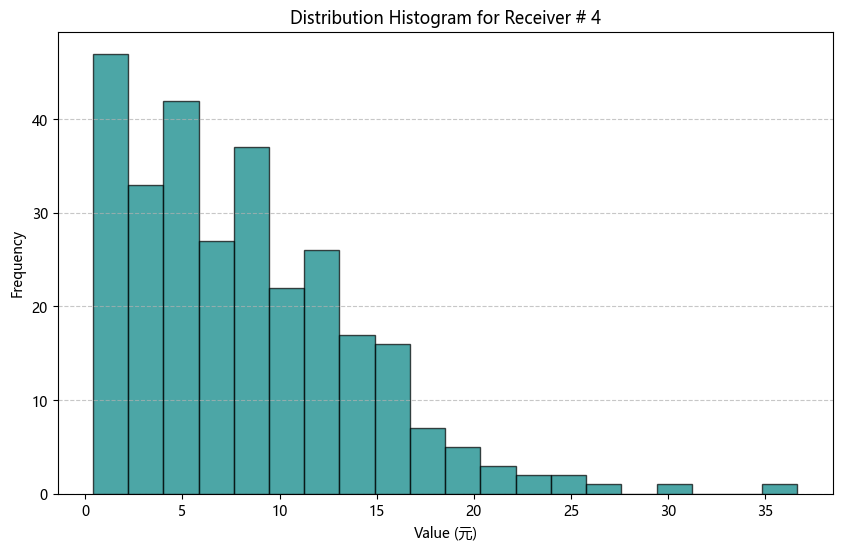

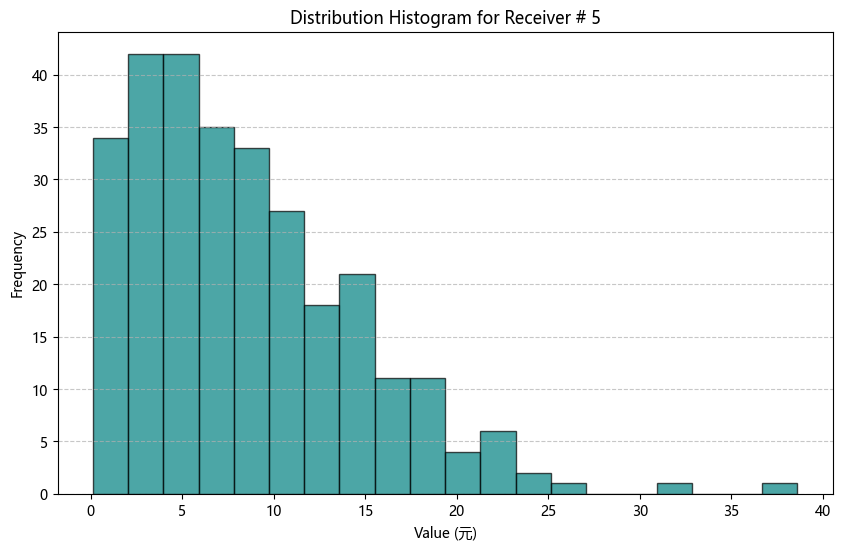

In [16]:
# Load Wechat_Samples.json if it exists, otherwise process snapshots
data_path = os.path.join(DATABASE_DIR, "Wechat_Samples.json")

if os.path.exists(data_path):
    print(f"Loading data from {data_path}...")
    try:
        with open(data_path, "r", encoding="utf-8") as f:
            all_data = json.load(f)
        # print(f"Loaded {len(all_data)} data groups from {data_path}")
        visualize_data(all_data)
    except Exception as e:
        print(f"Error loading data from file: {e}")
        print("Falling back to processing snapshots...")
        process_all_snapshots()
else:
    process_all_snapshots()

# Task3 Distribution Modeling
We construct two models: **Normal** and **Conditional Uniform** to try to explain the data distribution.
## Normal Model
We estimate the Normal parameters $\mu$ and $\sigma$ by using Maximum Likelihood Estimation method and generate an
example sample data from model following the experienced normal distribution.
### 1. Core Idea

*   **Likelihood Function:** $L(\theta | x_1, ..., x_n)$ represents the **probability** (discrete) or **probability density** (continuous) of observing the specific dataset $x_1, ..., x_n$ given the parameter $\theta$.
*   **Maximization:** MLE aims to find a set of parameters $\hat{\theta}$ that maximizes the likelihood function $L(\theta | ...)$. This $\hat{\theta}$ is our estimate for the true parameter $\theta$.
* ## 2. Applying MLE to Estimate Normal Distribution Parameters

**Assumption:** We have $n$ independent and identically distributed (i.i.d.) observations $x_1, x_2, ..., x_n$, drawn from a Normal distribution $N(\mu, \sigma^2)$ with unknown mean $\mu$ and unknown variance $\sigma^2$.

#### 2.1. Write the Likelihood Function

*   Because the observations are independent, the joint probability density is the product of individual densities.
*   $f(x_i | \mu, \sigma^2)$ is the probability density function (PDF) of the Normal distribution.
*   $L(\mu, \sigma^2 | x_1, ..., x_n)$ is the likelihood function.

$$
L(\mu, \sigma^2 | x_1, ..., x_n) = \prod_{i=1}^{n} f(x_i | \mu, \sigma^2)
$$

$$
f(x_i | \mu, \sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(x_i - \mu)^2}{2\sigma^2}\right)
$$

$$
L(\mu, \sigma^2) = \prod_{i=1}^{n} \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(x_i - \mu)^2}{2\sigma^2}\right) \tag{1}
$$

#### 2.2. Take the Log-Likelihood Function

*   To simplify differentiation and calculation (turning products into sums), take the natural logarithm of the likelihood function.
*   $\ell(\mu, \sigma^2)$ is the log-likelihood function.

$$
\ell(\mu, \sigma^2) = \log L(\mu, \sigma^2) = \sum_{i=1}^{n} \log\left(\frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(x_i - \mu)^2}{2\sigma^2}\right)\right) \tag{2}
$$

Expand and simplify (using logarithm properties):

$$
\ell(\mu, \sigma^2) = \sum_{i=1}^{n} \left[ \log\left((2\pi\sigma^2)^{-1/2}\right) + \log\left(\exp\left(-\frac{(x_i - \mu)^2}{2\sigma^2}\right)\right) \right]
$$

$$
= \sum_{i=1}^{n} \left[ -\frac{1}{2}\log(2\pi) - \frac{1}{2}\log(\sigma^2) - \frac{(x_i - \mu)^2}{2\sigma^2} \right] \tag{3}
$$

$$
= -\frac{n}{2}\log(2\pi) - \frac{n}{2}\log(\sigma^2) - \frac{1}{2\sigma^2}\sum_{i=1}^{n}(x_i - \mu)^2 \tag{4}
$$

#### 2.3. Differentiate with Respect to Parameters and Set to Zero

*   To find the maximum, differentiate with respect to $\mu$ and $\sigma^2$ separately, and set the results equal to zero.

##### 2.3.1. Differentiate with Respect to $\mu$

*   Treat $\sigma^2$ as a constant when differentiating with respect to $\mu$.

$$
\frac{\partial \ell}{\partial \mu} = \frac{\partial}{\partial \mu} \left( -\frac{n}{2}\log(2\pi) - \frac{n}{2}\log(\sigma^2) - \frac{1}{2\sigma^2}\sum_{i=1}^{n}(x_i - \mu)^2 \right)
$$

$$
= 0 - 0 - \frac{1}{2\sigma^2} \cdot \sum_{i=1}^{n} \frac{\partial}{\partial \mu} (x_i - \mu)^2
$$

$$
= - \frac{1}{2\sigma^2} \cdot \sum_{i=1}^{n} 2(x_i - \mu) \cdot (-1) \tag{Chain Rule}
$$

$$
= \frac{1}{\sigma^2}\sum_{i=1}^{n}(x_i - \mu) \tag{5}
$$

Set $\frac{\partial \ell}{\partial \mu} = 0$:

$$
\sum_{i=1}^{n}(x_i - \mu) = 0 \implies \sum_{i=1}^{n}x_i - n\mu = 0 \implies \sum_{i=1}^{n}x_i = n\mu \implies \mu = \frac{1}{n}\sum_{i=1}^{n}x_i \tag{6}
$$

##### 2.3.2. Differentiate with Respect to $\sigma^2$

*   Treat $\mu$ as a constant (using the value solved for in Step 2.3.1), when differentiating with respect to $\sigma^2$.

$$
\frac{\partial \ell}{\partial \sigma^2} = \frac{\partial}{\partial \sigma^2} \left( -\frac{n}{2}\log(2\pi) - \frac{n}{2}\log(\sigma^2) - \frac{1}{2\sigma^2}\sum_{i=1}^{n}(x_i - \mu)^2 \right)
$$

$$
= 0 - \frac{n}{2} \cdot \frac{1}{\sigma^2} - \sum_{i=1}^{n}(x_i - \mu)^2 \cdot \frac{\partial}{\partial \sigma^2} \left( \frac{1}{2\sigma^2} \right)
$$

$$
= -\frac{n}{2\sigma^2} - \sum_{i=1}^{n}(x_i - \mu)^2 \cdot \left( -\frac{1}{2(\sigma^2)^2} \right) \tag{Derivative of 1/x w.r.t. x}
$$

$$
= -\frac{n}{2\sigma^2} + \frac{1}{2(\sigma^2)^2}\sum_{i=1}^{n}(x_i - \mu)^2 \tag{7}
$$

Set $\frac{\partial \ell}{\partial \sigma^2} = 0$:

$$
-\frac{n}{2\sigma^2} + \frac{1}{2(\sigma^2)^2}\sum_{i=1}^{n}(x_i - \mu)^2 = 0
$$

$$
\frac{n}{2\sigma^2} = \frac{1}{2(\sigma^2)^2}\sum_{i=1}^{n}(x_i - \mu)^2
$$

Multiply both sides by $2(\sigma^2)^2$:

$$
n \cdot \sigma^2 = \sum_{i=1}^{n}(x_i - \mu)^2 \implies \sigma^2 = \frac{1}{n}\sum_{i=1}^{n}(x_i - \mu)^2 \tag{8}
$$

#### 2.4. Obtain the MLE Estimators

*   Substitute the $\hat{\mu}$ value obtained from equation (6) into equation (8).

*   **MLE estimator for mean $\mu$:**
    $$
    \hat{\mu}_{MLE} = \frac{1}{n}\sum_{i=1}^{n}x_i \tag{9}
    $$

*   **MLE estimator for variance $\sigma^2$:**
    $$
    \hat{\sigma}^2_{MLE} = \frac{1}{n}\sum_{i=1}^{n}(x_i - \hat{\mu}_{MLE})^2 \tag{10}
    $$
### 3. Conclusion

Through the MLE method, we derived that:

*   The best estimate for the mean $\mu$ of a Normal distribution is the **sample mean**.
*   The best estimate for the variance $\sigma^2$ of a Normal distribution is the **sample variance with denominator $n$**.

In [ ]:
def load_data(json_file_path):
    if not os.path.exists(json_file_path):
        raise FileNotFoundError(f"JSON file '{json_file_path}' not found in the current directory.")
    try:
        with open(json_file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        return data
    except Exception as e:
        print(f"Error loading JSON file: {e}")
        return None


def model_normal_distribution(data):
    print("\n--- Model 1: Normal Distribution ---")
    all_amounts = [amount for round_sample in data for amount in round_sample]
    sample_mean = np.mean(all_amounts)
    sample_std = np.std(all_amounts, ddof=0)
    mu = sample_mean
    sigma = sample_std
    print(f"Estimated Mean (μ): {mu:.4f}")
    print(f"Estimated Std Dev (σ): {sigma:.4f}")
    print(f"Model: X ～ N({mu:.4f}, {sigma:.4f}^2)")
    sample_from_model = np.round(np.random.normal(loc=mu, scale=sigma, size=6), 2) ## General example sample data
    print(f"Example sample from model (probably does not sum to total value): {sample_from_model.tolist()}")
    return mu, sigma

## Conditional Uniform Model
By applying a hypothesized distribution rule :
**Every single r.v. follows uniform distribution with lower bound 0.01 and higher bound 2 times average of the remaining**, we construct this **conditional** uniform model and use it to generate an example sample data with n steps
(n equals to the total number of red packets).

In [ ]:
def estimate_total_amount(data):
    totals_per_round = [sum(round_sample) for round_sample in data]
    estimated_total = np.mean(totals_per_round)
    return estimated_total

def generate_uniform_round_v2(total_amount=50.0):
    amounts = []
    remaining_amount = total_amount
    remaining_people = 6

    for i in range(5):
        remaining_avg = remaining_amount / remaining_people
        upper_bound = min(2 * remaining_avg, remaining_amount)
        lower_bound = 0.01

        new_amount = np.random.uniform(low=lower_bound, high=upper_bound)
        new_amount = min(new_amount, remaining_amount - (remaining_people - 1) * 0.01)

        amounts.append(round(float(new_amount), 2))
        remaining_amount -= new_amount
        remaining_people -= 1

        if remaining_amount < remaining_people * 0.01:
             print("Warning: Generated amounts may not allow for minimum 0.01 for remaining people.")
             break

    if len(amounts) == 5:
        last_amount = round(float(remaining_amount), 2)
        amounts.append(last_amount)
    else:
        while len(amounts) < 6:
            amounts.append(0.0)

    return amounts


def model_uniform_distribution(data):
    print("\n--- Model 2: Uniform Distribution ---")
    estimated_total = estimate_total_amount(data)
    print(f"Estimated Total Amount per Round: {estimated_total:.2f}")
    print(f"Model Rule: For each of the first 5 amounts in a round:")
    print(f"  Amount_i ～ U(0.01, min(2 * RemainingAvg, RemainingAmount))")
    print(f"  The 6th amount is set to Total_Amount - Sum_of_first_5_amounts")
    print(f"Using Estimated Total Amount: {estimated_total:.2f}")
    generated_round = generate_uniform_round_v2(total_amount=estimated_total)
    print(f"Example generated round from model: {generated_round}")
    print(f"Sum of generated round: {sum(generated_round):.2f}")
    return estimated_total

## Main

In [ ]:
samples_data = load_data("Database/Wechat_Samples.json")
if samples_data is None:
    print("Failed to load data. Exiting.")
    exit()

mu, sigma = model_normal_distribution(samples_data)
total_amt = model_uniform_distribution(samples_data)

print("\n--- Summary ---")
print(f"Model 1 (Normal Distribution): X ~ N(mean={mu:.4f}, std={sigma:.4f})")
print(f"Model 2 (Uniform Distribution): Xi ~ Unif(0.01, 2*(S-Si)/n-i")

![image.png](Plots/Model%20Output.png)
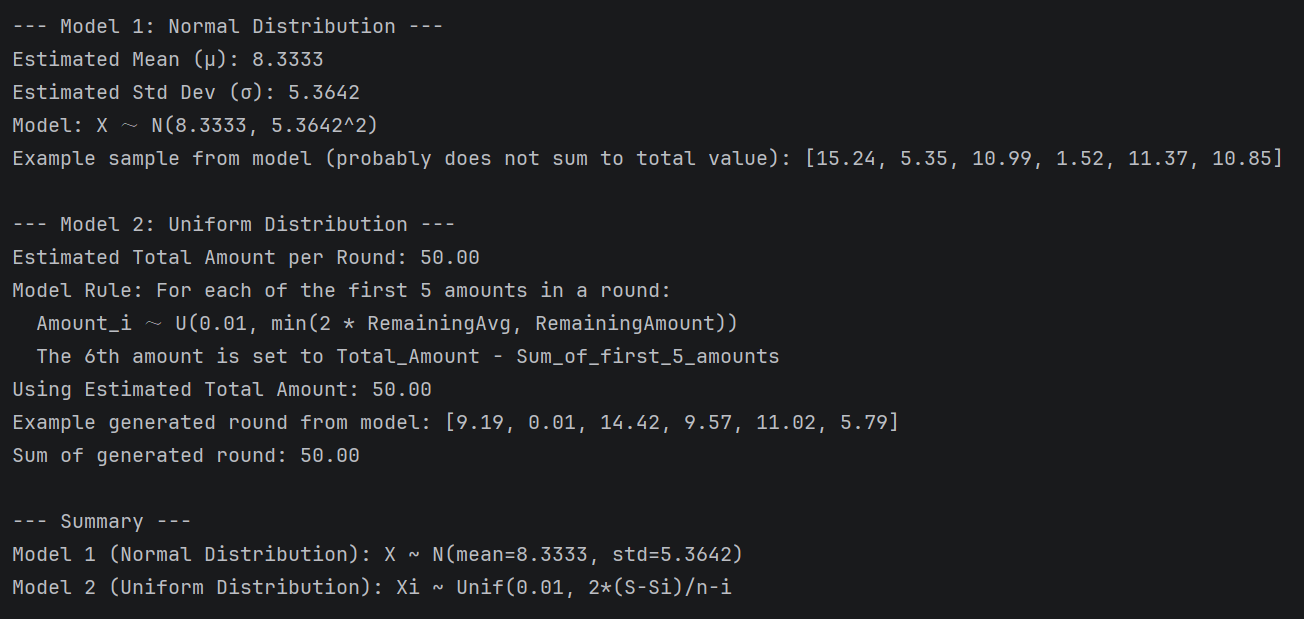

## Further Exploration
### (d) User-specific WRE mechanism
Based on the original model, we further enhance it to satisfy different groups of user's need and apply it in many different situations
### Example 1: Child Group
#### Problem: Children want fairness due to differences in amounts received.
#### Optimization: Reduce randomness, increase fairness, ensuring the amount difference is not too large.
#### Solution: "Gentle Randomness" + "Minimum Guarantee Constraint"

In [2]:
import numpy as np

def generate_children_red_envelope(total_amount=50.0, num_people=6):
    # 每人基础金额 = total / num_people
    base = total_amount / num_people
    # 加上微小扰动，但仍控制在 ±10% 范围内
    amounts = []
    remaining = total_amount

    for i in range(num_people - 1):
        # 添加小范围浮动，确保不会太离谱
        fluctuation = np.random.uniform(-0.1 * base, 0.1 * base)
        amount = max(0.01, base + fluctuation)
        # 确保不超过剩余额度
        amount = min(amount, remaining - (num_people - 1 - i) * 0.01)
        amounts.append(round(float(amount), 2))
        remaining -= amount

    last_amount = round(float(remaining), 2)
    amounts.append(last_amount)

    return amounts

amounts = generate_children_red_envelope(30.0, 6)
print("🎈 幼儿园小朋友抢红包示例 (总额30元，6个小朋友)")
print("分配结果:", amounts)
print("每人金额:", [f"{amount}元" for amount in amounts])
print("最大金额:", max(amounts), "元")
print("最小金额:", min(amounts), "元")
print("金额差值:", max(amounts) - min(amounts), "元")

🎈 幼儿园小朋友抢红包示例 (总额30元，6个小朋友)
分配结果: [4.98, 5.37, 5.37, 5.43, 5.29, 3.55]
每人金额: ['4.98元', '5.37元', '5.37元', '5.43元', '5.29元', '3.55元']
最大金额: 5.43 元
最小金额: 3.55 元
金额差值: 1.88 元


### Example 2: Company Group
#### Problem: When the boss sends a red envelope, they want to show generosity while avoiding embarrassment caused by large disparities among employees.
#### Optimization: Set aside a "bonus" for the boss (e.g., a fixed proportion for themselves), then use a relatively fair distribution for employees.
#### Solution: "Boss Privilege" + "Employee Gentle Randomness"

In [5]:
def generate_company_red_envelope(total_amount=50.0, roles=['boss', 'employee', 'employee', 'employee', 'employee', 'employee']):
    # 假设 boss 不想抢太多，只拿 1～3 元作为象征
    # 其他人按正常分布
    amounts = []
    remaining = total_amount
    role_map = {'boss': 0.01, 'employee': 0.01}  # 最低限额

    # 先处理非 boss 成员
    non_boss_count = sum(1 for r in roles if r != 'boss')
    non_boss_avg = (total_amount - 3.0) / non_boss_count  # 给 boss 预留 3 元上限

    for role in roles:
        if role == 'boss':
            boss_amount = np.random.uniform(0.01, 3.0)
            amounts.append(round(boss_amount, 2))
            remaining -= boss_amount
        else:
            # 正常员工分配
            upper_bound = min(2 * non_boss_avg, remaining)
            amount = np.random.uniform(0.01, upper_bound)
            amount = min(amount, remaining - (non_boss_count - len(amounts)) * 0.01)
            amounts.append(round(amount, 2))
            remaining -= amount

    # 最后一人补足
    if len(amounts) < len(roles):
        amounts.append(round(remaining, 2))

    return amounts

roles = ['boss', 'employee', 'employee', 'employee', 'employee', 'employee']
amounts = generate_company_red_envelope(100.0, roles)
print("\n🏢 公司团队抢红包示例 (总额100元，1位老板+5位员工)")
print("分配结果:", amounts)
print("老板获得:", amounts[0], "元")
print("员工获得:", [f"{amount}元" for amount in amounts[1:]])
print("员工平均:", round(sum(amounts[1:]) / 5, 2), "元")


🏢 公司团队抢红包示例 (总额100元，1位老板+5位员工)
分配结果: [2.98, 23.4, 9.8, 3.1, 32.16, 5.15]
老板获得: 2.98 元
员工获得: ['23.4元', '9.8元', '3.1元', '32.16元', '5.15元']
员工平均: 14.72 元


### Example 3: Family Member Group
#### Problem: Family relationships are complex; sometimes there's a desire to give more to closer relatives.
#### Optimization: Introduce "intimacy weights" to influence the random range or final amounts during distribution.
#### Solution: "Weight Influences Random Upper Limit"

In [9]:
def generate_family_red_envelope(total_amount=88.0, weights=None, members=None):
    if weights is None:
        # 默认权重：父母(高)、配偶/子女(中)、远亲(低)
        weights = [3.0, 3.0, 2.0, 2.0, 1.0, 0.5]
    if members is None:
        members = ['父亲', '母亲', '儿子', '女儿', '叔叔', '表哥']

    num_people = len(weights)
    normalized_weights = [w / sum(weights) for w in weights]

    amounts = []
    remaining = total_amount

    for i in range(num_people - 1):
        weight = normalized_weights[i]
        expected = total_amount * weight
        fluctuation = np.random.uniform(-0.2 * expected, 0.2 * expected)
        amount = max(0.01, expected + fluctuation)
        amount = min(amount, remaining - (num_people - 1 - i) * 0.01)
        amounts.append(round(float(amount), 2))
        remaining -= amount

    amounts.append(round(float(remaining), 2))

    return dict(zip(members, amounts))

weights = [3.0, 3.0, 2.0, 2.0, 1.0, 0.5]  # 父母>子女>叔叔>表哥
members = ['父亲', '母亲', '儿子', '女儿', '叔叔', '表哥']
result = generate_family_red_envelope(88.0, weights, members)

print("\n👨‍👩‍👧‍👦 家庭春节红包示例 (总额88元，6位亲戚)")
print("分配结果:")
for member, amount in result.items():
    print(f"  {member}: {amount}元")

print("\n金额排序(从高到低):")
sorted_result = sorted(result.items(), key=lambda x: x[1], reverse=True)
for member, amount in sorted_result:
    print(f"  {member}: {amount}元")


👨‍👩‍👧‍👦 家庭春节红包示例 (总额88元，6位亲戚)
分配结果:
  父亲: 23.3元
  母亲: 25.09元
  儿子: 13.12元
  女儿: 16.46元
  叔叔: 7.0元
  表哥: 3.02元

金额排序(从高到低):
  母亲: 25.09元
  父亲: 23.3元
  女儿: 16.46元
  儿子: 13.12元
  叔叔: 7.0元
  表哥: 3.02元


## (e) Fairness-ware WRE mechanism
### Purpose:
A compensation mechanism which change the weights of algorithm when someone unluckily get less money than other people.
### Solution:
#### 1. Record the historical average income of each user.
#### 2. When someone's amount is consistently below average → give them higher weight or priority guarantee in the next red envelope distribution.
#### 3. Use a "fairness coefficient" to adjust allocation probabilities.

In [11]:
import numpy as np
from collections import defaultdict

class FairnessAwareRedEnvelope:
    def __init__(self):
        self.history = defaultdict(list)  # user_id -> list of received amounts
        self.total_sent = 0

    def send_red_envelope(self, total_amount, users, sender=None):
        """
        发送一个红包，考虑历史公平性
        """
        n = len(users)
        if n == 0:
            return []

        # Step 1: 计算每个用户的当前平均收益
        avg_amounts = {}
        for u in users:
            if u in self.history:
                avg_amounts[u] = sum(self.history[u]) / len(self.history[u])
            else:
                avg_amounts[u] = 0.0

        # Step 2: 计算“公平分数”：越低的人越需要补偿
        fairness_scores = {u: 1.0 / (avg_amounts[u] + 0.1) for u in users}
        total_score = sum(fairness_scores.values())
        weights = {u: fairness_scores[u] / total_score for u in users}

        # Step 3: 基于权重进行带偏置的分配
        amounts = []
        remaining = total_amount
        remaining_people = n

        for i in range(n - 1):
            u = users[i]
            # 使用权重影响期望值
            expected = total_amount * weights[u]
            # 控制波动范围
            upper_bound = min(2 * expected, remaining)
            lower_bound = 0.01
            new_amount = np.random.uniform(lower_bound, upper_bound)
            new_amount = min(new_amount, remaining - (remaining_people - 1) * 0.01)
            amounts.append(round(new_amount, 2))
            remaining -= new_amount
            remaining_people -= 1

        amounts.append(round(remaining, 2))

        # Step 4: 更新历史记录
        for i, u in enumerate(users):
            self.history[u].append(amounts[i])

        return amounts

faire = FairnessAwareRedEnvelope()
users = ['A', 'B', 'C', 'D', 'E']

# 第一次发红包
print("Round 1:", faire.send_red_envelope(50.0, users))

# 第二次发红包
print("Round 2:", faire.send_red_envelope(50.0, users))

# 第三次发红包：假设 C 很不幸，总金额很低
print("Round 3:", faire.send_red_envelope(50.0, users))

Round 1: [7.34, 3.31, 16.23, 10.19, 12.93]
Round 2: [19.4, 8.4, 2.32, 3.85, 16.04]
Round 3: [6.93, 13.38, 12.44, 10.59, 6.66]
